<a href="https://colab.research.google.com/github/regs08/lab_utils/blob/main/hsi_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.3 MB/s eta 0:00:00


In [3]:
from spectral import open_image
import os

In [7]:
%cd /content
!unzip assets.zip


/content
Archive:  assets.zip
   creating: assets/
  inflating: __MACOSX/._assets       
  inflating: assets/.DS_Store        
  inflating: __MACOSX/assets/._.DS_Store  
   creating: assets/HSI_image_004/
  inflating: __MACOSX/assets/._HSI_image_004  
  inflating: assets/HSI_image_004/DARKREF_2020-09-10_004.raw  
  inflating: __MACOSX/assets/HSI_image_004/._DARKREF_2020-09-10_004.raw  
  inflating: assets/HSI_image_004/2020-09-10_004.hdr  
  inflating: __MACOSX/assets/HSI_image_004/._2020-09-10_004.hdr  
  inflating: assets/HSI_image_004/WHITEREF_2020-09-10_004.raw  
  inflating: __MACOSX/assets/HSI_image_004/._WHITEREF_2020-09-10_004.raw  
  inflating: assets/HSI_image_004/RGBVIEWFINDER_2020-09-10_004.png  
  inflating: __MACOSX/assets/HSI_image_004/._RGBVIEWFINDER_2020-09-10_004.png  
  inflating: assets/HSI_image_004/2020-09-10_004.xml  
  inflating: __MACOSX/assets/HSI_image_004/._2020-09-10_004.xml  
  inflating: assets/HSI_image_004/2020-09-10_004.png  
  inflating: __MACOSX/asse

Preprocessing

In [8]:
working_dir = os.getcwd()
working_dir

'/content'

Data from: https://entrepot.recherche.data.gouv.fr/dataset.xhtml?persistentId=doi:10.57745/WW7TY7


In [9]:
hsi_image_dir = os.path.join(working_dir, 'assets', 'HSI_image_004')

# Define paths for the raw cube and reference images
raw_cube_path = os.path.join(hsi_image_dir, '2020-09-10_004.hdr')
dark_ref_path = os.path.join(hsi_image_dir, 'DARKREF_2020-09-10_004.hdr')
white_ref_path = os.path.join(hsi_image_dir, 'WHITEREF_2020-09-10_004.hdr')

# Load the raw data cube and reference images
raw_cube = open_image(raw_cube_path).load()
dark_ref = open_image(dark_ref_path).load()
white_ref = open_image(white_ref_path).load()



In [10]:
# Calibrate the Data
reflectance_cube = (raw_cube - dark_ref) / (white_ref - dark_ref)
reflectance_cube.shape # Output: (rows, columns, bands)

(512, 512, 204)

In [11]:
###
# Extract Pixel Spectra
###
x, y = 200,200  # Example pixel
spectrum = reflectance_cube[x, y, :]
wavelengths_path = os.path.join(hsi_image_dir, 'REFLECTANCE_2020-09-10_004.hdr')
wavelengths = list(map(float, open_image(wavelengths_path).metadata['wavelength']))


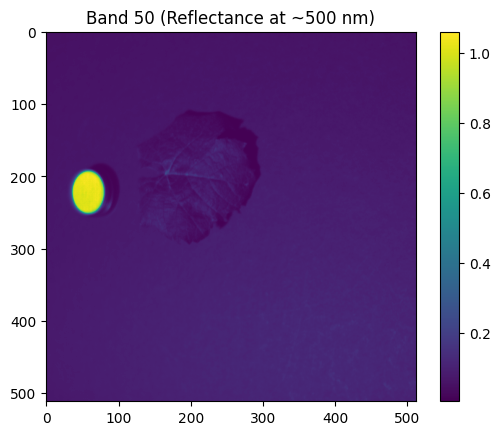

In [12]:
# Visualize bands on whole image
import matplotlib.pyplot as plt
band = 50 # Example band
plt.imshow(reflectance_cube[:, :, band], cmap='viridis')
plt.title("Band 50 (Reflectance at ~500 nm)")
plt.colorbar()
plt.show()

In [13]:
###
# Calculate Spectral Indices (e.g., NDVI)
###
# Load the metadata from the .hdr file

hdr_file_path = os.path.join(hsi_image_dir, 'REFLECTANCE_2020-09-10_004.hdr')
hdr = open_image(hdr_file_path).metadata

In [14]:
def find_closest_band(hdr_file_path, target_wavelength):
    """
    Finds the closest wavelength to the target in the .hdr file's wavelength array.

    Args:
        hdr_file_path (str): Path to the .hdr file.
        target_wavelength (float): The wavelength to search for (in nm).

    Returns:
        tuple: (closest_band_index, closest_wavelength)
    """
    # Load the metadata from the .hdr file
    hdr = open_image(hdr_file_path).metadata

    # Extract the wavelengths as a list of floats
    wavelengths = list(map(float, hdr['wavelength']))

    # Find the index of the closest wavelength
    closest_band_index = min(range(len(wavelengths)), key=lambda i: abs(wavelengths[i] - target_wavelength))
    closest_wavelength = wavelengths[closest_band_index]

    return closest_band_index, closest_wavelength

Band 1 wavelength: 400.2 nm
Band 150 wavelength: 1000.49 nm


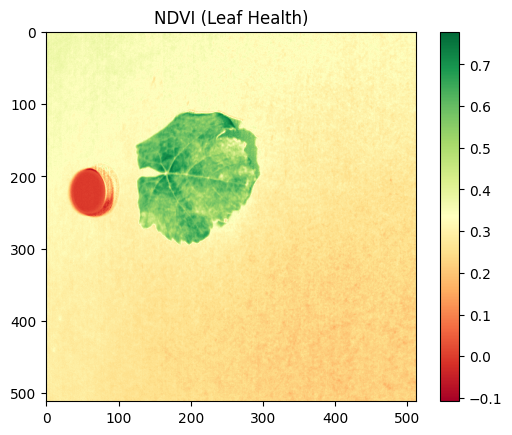

In [15]:
target_red = 400
target_nir = 1000

# Find the closest bands
red_band_index, red_wavelength = find_closest_band(hdr_file_path, target_red)
nir_band_index, nir_wavelength = find_closest_band(hdr_file_path, target_nir)
# Extract the wavelength array
wavelengths = list(map(float, hdr['wavelength']))

# Check the wavelengths for specific band indices
print(f"Band {red_band_index} wavelength: {wavelengths[red_band_index]} nm")
print(f"Band 150 wavelength: {wavelengths[nir_band_index]} nm")
red_band = reflectance_cube[:, :, 100]  # Red (~680 nm)
nir_band = reflectance_cube[:, :, 150]  # NIR (~800 nm)
ndvi = (nir_band - red_band) / (nir_band + red_band)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title("NDVI (Leaf Health)")
plt.colorbar()
plt.show()